### ASTR 3970 / 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 1st at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (100 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $2000$ bootstrap realizations of this dataset. Using an appropriate timing function in python, how long did the generation of these realizations take? 
*DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together. This code will be graded on efficiency and speed; it should not take more than 1 second to execute.*

5) Repeat (2) with all $2000$ boostrap datasets to find the distribution of the sample mean. How long did this take? Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $2000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [45]:
!pip install numdifftools

### Solution

Part 1

In [46]:
import numdifftools as nd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

#load in data
hw_data = np.load("../../../homeworks/hw_data/hw3_data_1.npy")

#grab each column
def column(matrix, i):
    return [row[i] for row in matrix]

measurements = column(hw_data, 0) #the measurements
uncertainties = column(hw_data, 1) #the uncertainties
mean = np.sum(measurements/np.power(uncertainties,2))/(np.sum(1/np.power(uncertainties,2))) #calculating the sample mean
error = (np.sum(1/np.power(uncertainties,2)))**(-1/2) #calculating the standard error
print('the sample mean is',mean,'and the standard error is',error)

the sample mean is 4.082099776157917 and the standard error is 0.0937975025520293


SRT: Good. But note that you don't need that column function with the list comprehension. Just use `hw_data[:,0]` and `hw_data[:,1]`

-1 point

Part 2

In [47]:
#the log likelihood function of a heteroscedastic gaussian
def logL(guess, measurement, errors):
    ln_likelihood = np.sum((-1/2)*np.log(2*np.pi*np.power(errors,2)))-np.sum((measurement-guess)**2/(2*np.power(errors, 2)))
    return -ln_likelihood #return the negative to minimize for optimize.fmin

from scipy import optimize
f_logL = lambda beta: logL(beta, measurements, uncertainties)

# compute the maximum likelihood 
beta0 = 3 # initial guess
beta_logL = optimize.fmin(f_logL, beta0) #minimize function
print('the best fit mean is', beta_logL)

Optimization terminated successfully.
         Current function value: 153.618547
         Iterations: 16
         Function evaluations: 32
the best fit mean is [4.08208008]


SRT: Good

Part 3

In [48]:
#the Hessian
H = nd.Hessian(f_logL)([beta_logL[0]])
sigma_laplace = np.linalg.inv(H)**0.5
print('the Fisher uncertainty estimate on the mean is',sigma_laplace)


the Fisher uncertainty estimate on the mean is [[0.0937975]]


SRT: Correct, but the method in Lecture 5 used a finite differencing estimate of the second derivative of the log likelihood. -1 point

Part 4

In [49]:
import time

#the bootstrap method
def bootstrap(data,N):
    bootstrap_samples = []
    for i in range(0,N):
        bootstrap_sample = data[np.random.choice(len(measurements),size=len(hw_data), replace=True)] #chooses a random index from the data set
        bootstrap_samples.append(bootstrap_sample) 

    return np.array(bootstrap_samples)
start = time.time()
bootstrap_array = bootstrap(hw_data, 2000) #2000 realizations of our data set
end = time.time()
print('the time it took in seconds',end-start)


the time it took in seconds 0.01636528968811035


Part 5

<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3560/3751091199.py:20: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('distribution of $\mu$')


the time it took in seconds 0.7906291484832764


Text(0, 0.5, 'normalized counts')

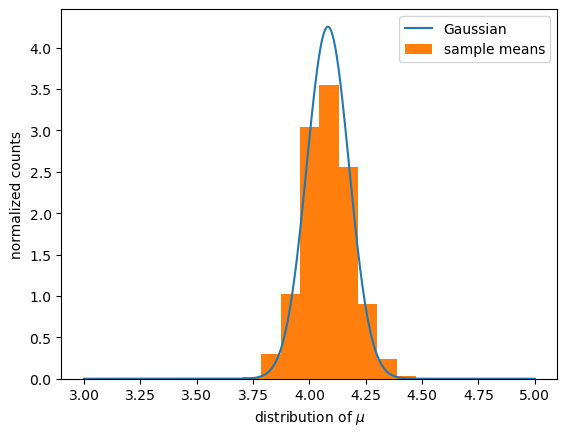

In [50]:
import scipy.stats

sample_means = []
start = time.time()
#repeating step 2 for all 2000 realizations
for i in range(2000):
    f_logL = lambda beta: logL(beta, bootstrap_array[i,:,0], bootstrap_array[i,:,1])
    beta0 = 3 # complete for initial guess
    sample_mean = optimize.fmin(f_logL, beta0, disp=False)
    sample_means.append(sample_mean)
end = time.time()
print('the time it took in seconds',end-start)
sample_means = np.array(sample_means)
#now plot
xgrid = np.linspace(3,5,1000) # Array to sample the space 
distG = scipy.stats.norm(mean,error) # Complete
plt.plot(xgrid, distG.pdf(xgrid), label='Gaussian') # Complete
plt.hist(sample_means, density=True, label='sample means')
plt.legend()
plt.xlabel('distribution of $\mu$')
plt.ylabel('normalized counts')

SRT: Very good, Azeem. Note that the x-axis is just mu, not distribution of mu. That's a more appropriate label for y.

Part 6

In [51]:
#log likelihood of laplace distribution
def lnlaplace(mu, b, data):
    n = len(data)
    log_likelihood = -n * np.log(2 * b) - np.sum(np.abs(data - mu)) / b #pretty sure this is right
    return -log_likelihood #return negative to minimize the function

f_lnlaplace = lambda beta: lnlaplace(beta[0], beta[1], measurements)
# compute the maximum likelihood 
beta_params = (3,1) # initial guess for loc and scale
beta_lnlaplace = optimize.fmin(f_lnlaplace, beta_params)
loc = beta_lnlaplace[0]
scale = beta_lnlaplace[1]
print('the location parameter is', loc, 'and the scale parameter is', scale)


Optimization terminated successfully.
         Current function value: 161.631942
         Iterations: 47
         Function evaluations: 88
the location parameter is 4.089887652271702 and the scale parameter is 0.9260493721621862


SRT: Good

Part 7

In [52]:
#define function for the AIC
def aic(lnl, k , N):
    aic_laplace = -2*lnl + 2*k + (2*k*(k+1))/(N-k-1)
    return aic_laplace

#find maximum likelihood for gauss and laplacian 
lnl_gauss = -logL(beta_logL, measurements, uncertainties)
lnl_laplace = -lnlaplace(loc,scale, measurements)

#find AIC value
aic_gauss = aic(lnl_gauss, 1, len(measurements))
aic_laplace = aic(lnl_laplace, 2, len(measurements))
print('the AIC for the gaussian is',aic_gauss, 'and the AIC for the laplacian is',aic_laplace)
print('Gauss is more favoured')

the AIC for the gaussian is 309.2779093532689 and the AIC for the laplacian is 327.38759523958527
Gauss is more favoured


Part 8

Optimization terminated successfully.
         Current function value: 149.371730
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: 163.761903
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: 166.016424
         Iterations: 53
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 170.917938
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: 164.726673
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: 155.121854
         Iterations: 55
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 178.683401
         Iterations: 50
         Function evaluations: 91
Optimization te

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3560/3084271679.py:12: SyntaxWarning: invalid escape sequence '\m'
  corner.corner(param_resample, levels=[0.68, 0.95],show_titles=True, title_kwargs={"fontsize": 12}, quantiles=[0.16, 0.50, 0.84],labels=["$\mu$", "$\Delta$"])
/tmp/ipykernel_3560/3084271679.py:12: SyntaxWarning: invalid escape sequence '\D'
  corner.corner(param_resample, levels=[0.68, 0.95],show_titles=True, title_kwargs={"fontsize": 12}, quantiles=[0.16, 0.50, 0.84],labels=["$\mu$", "$\Delta$"])


Optimization terminated successfully.
         Current function value: 156.650955
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: 159.856896
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: 163.874390
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: 176.226319
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 165.695521
         Iterations: 52
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: 160.859793
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 169.893540
         Iterations: 50
         Function evaluations: 96
Optimization termin

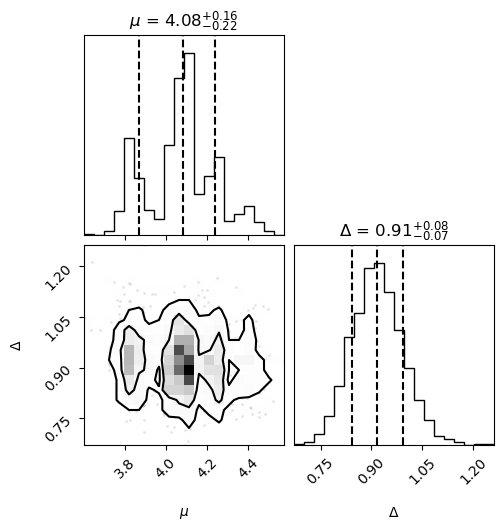

In [53]:
import corner
param_resample = []
#fit location and scale for all 2000 realizations
for i in range(2000):
    f_lnlaplace = lambda beta: lnlaplace(beta[0], beta[1], bootstrap_array[i,:,0])
    # compute the maximum likelihood 
    beta_lnlaplace = (3,1) # complete for initial guess
    beta_lnlaplace_resample = optimize.fmin(f_lnlaplace, beta_lnlaplace)
    param_resample.append(beta_lnlaplace_resample)
param_resample = np.array(param_resample).reshape([2000,2])
#make corner plot
corner.corner(param_resample, levels=[0.68, 0.95],show_titles=True, title_kwargs={"fontsize": 12}, quantiles=[0.16, 0.50, 0.84],labels=["$\mu$", "$\Delta$"])
plt.show()

SRT: Nice work

Part 9

In [54]:
import numdifftools as nd
#find hessian for laplacian
H = nd.Hessian(f_lnlaplace)(beta_lnlaplace)
sigma_laplace = np.linalg.inv(H)**0.5
diagonal = np.diag(sigma_laplace) #find the diagonal
print('the Fisher uncertainty on the location and scale is', diagonal)

the Fisher uncertainty on the location and scale is [0.17232368 0.09400038]


/tmp/ipykernel_3560/4162265008.py:4: RuntimeWarning: invalid value encountered in sqrt
  sigma_laplace = np.linalg.inv(H)**0.5


SRT: Correct method, but looks like you've accidentally used a tuple that was set to (3,1) in your loop in the previous question. Should have been the best-fit parameters. -2 points

SRT: 46/50